In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns
import pickle

import scanpy as sc
import scanpy.external as sce
import anndata as ad

import session_info
import warnings
from pyprojroot.here import here

import scienceplots
from sklearn.neighbors import NearestNeighbors
from typing import Iterable

warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

# Import custom functions
from customPythonFunctions import cumulative_explained_variance, balanced_sample, generateID2SymbolDF

print("Main directory path: {}".format(here()))

plt.style.use(['nature'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

Main directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas


**Setting parameters** 

In [2]:
overwriteFigures = True
overwriteData = True

In [3]:
cellGroup = 'RBC_and_HSC'
annotationDFpath = '/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas-/02_cell_annotation/SCGT00_CentralizedDataset/01_fromDataset_to_CellLineages/results/SCGT00_cluster_res0.1_annotated.pkl'
annotationColumns = 'cell_lineages'
workDir = os.getcwd()
level = workDir.split(os.path.sep)[-2]

**Loading the integrated object**

In [4]:
adataHVGint = sc.read_h5ad(here('{}/results/02_{}_{}_HVGsubset_scVI.h5ad'.format(workDir, level, cellGroup)))
adataHVGint

AnnData object with n_obs × n_vars = 1912 × 1341
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'disp

# Computing the projections of the embedded space

## Computing KNN graph and UMAP from the integrated embedded space

In [5]:
n_latent = adataHVGint.obsm['X_scVI'].shape[1]
sc.pp.neighbors(adataHVGint, n_neighbors=10, n_pcs=n_latent, use_rep = 'X_scVI', key_added = 'scVI')

2024-10-17 18:26:52.884381: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 18:26:52.887693: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-17 18:26:52.935155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-10-17 18:26:53.953903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT




Failed to import TF-Keras. Please note that TF-Keras is not installed by default when you install TensorFlow Probability. This is so that JAX-only users do not have to install TensorFlow or TF-Keras. To use TensorFlow Probability with TensorFlow, please install the tf-keras or tf-keras-nightly package.
This can be be done through installing the tensorflow-probability[tf] extra.




In [6]:
sc.tl.umap(adataHVGint, neighbors_key='scVI')

In [7]:
# Saving the umap computed on the scVI latent component
adataHVGint.obsm['X_umap_scVI'] = adataHVGint.obsm['X_umap'].copy()
adataHVGint.uns['umap_scVI'] = adataHVGint.uns['umap']

In [8]:
adataHVGint

AnnData object with n_obs × n_vars = 1912 × 1341
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'disp

**Plotting parameters** 

In [9]:
max_cells_plot = 200000
fraction = min(1, (max_cells_plot/adataHVGint.shape[0]))

### Feature scaling and centering

In [10]:
adataHVGint.X = adataHVGint.layers['log1p_10e4_counts']
sc.pp.scale(adataHVGint, zero_center = True)

**Loading the full object before HVG subsetting**

This will allows us to inspect genes that are not included in the HV set

In [11]:
adata_stepAll = ad.read_h5ad(here('{}/results/01_{}_normalized.h5ad'.format(workDir, cellGroup)))
adata_stepAll

AnnData object with n_obs × n_vars = 1912 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'disease_colors', 'log1p'
    layers: 'counts', 'log1p_

In [12]:
# Load the corresponding annotation
annotationDF = pd.read_pickle(here(annotationDFpath))
idxSelCells = annotationDF.index[annotationDF[annotationColumns] == cellGroup].tolist()
adata = adata_stepAll[idxSelCells,:]
adata

View of AnnData object with n_obs × n_vars = 1912 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'disease_colors', 'log1p'
    layers: 'counts',

In [13]:
del adata_stepAll

**Merging the objects**

We will transfer the following field to the fullObject: uns, obsm, and obsp. We will also transfer the HVG set

In [14]:
adata.uns = adataHVGint.uns.copy()
adata.obsm = adataHVGint.obsm.copy()
adata.obsp = adataHVGint.obsp.copy()
adata.var['highly_variable'] = False
adata.var['highly_variable'][adata.var_names.isin(adataHVGint.var_names)] = True

In [15]:
# Now we can remove from memory the subsetted adata object
del adataHVGint

# Save object

In [16]:
if overwriteData:
    adata.write(here("{}/results/03_{}_scVI_UMAP_clinical_allGenes.h5ad".format(workDir, cellGroup)), compression="gzip")

# Evaluate integration

At this point, it is important to evaluate the integration step to ensure the batch-effect have been removed, and the biological variance has been preserved. Here, we visually inspect some quality control metrics.

In [17]:
### To reduce the computational time, we are plotting only 10% of cells
SScells = balanced_sample(adata.obs, cols = ['sampleID'], n = None, frac = fraction, shuffle = True, random_state = 42)['cellID']
adataSS = adata[SScells].copy()
del adata
adataSS

AnnData object with n_obs × n_vars = 1912 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 

## Technical confounding factors

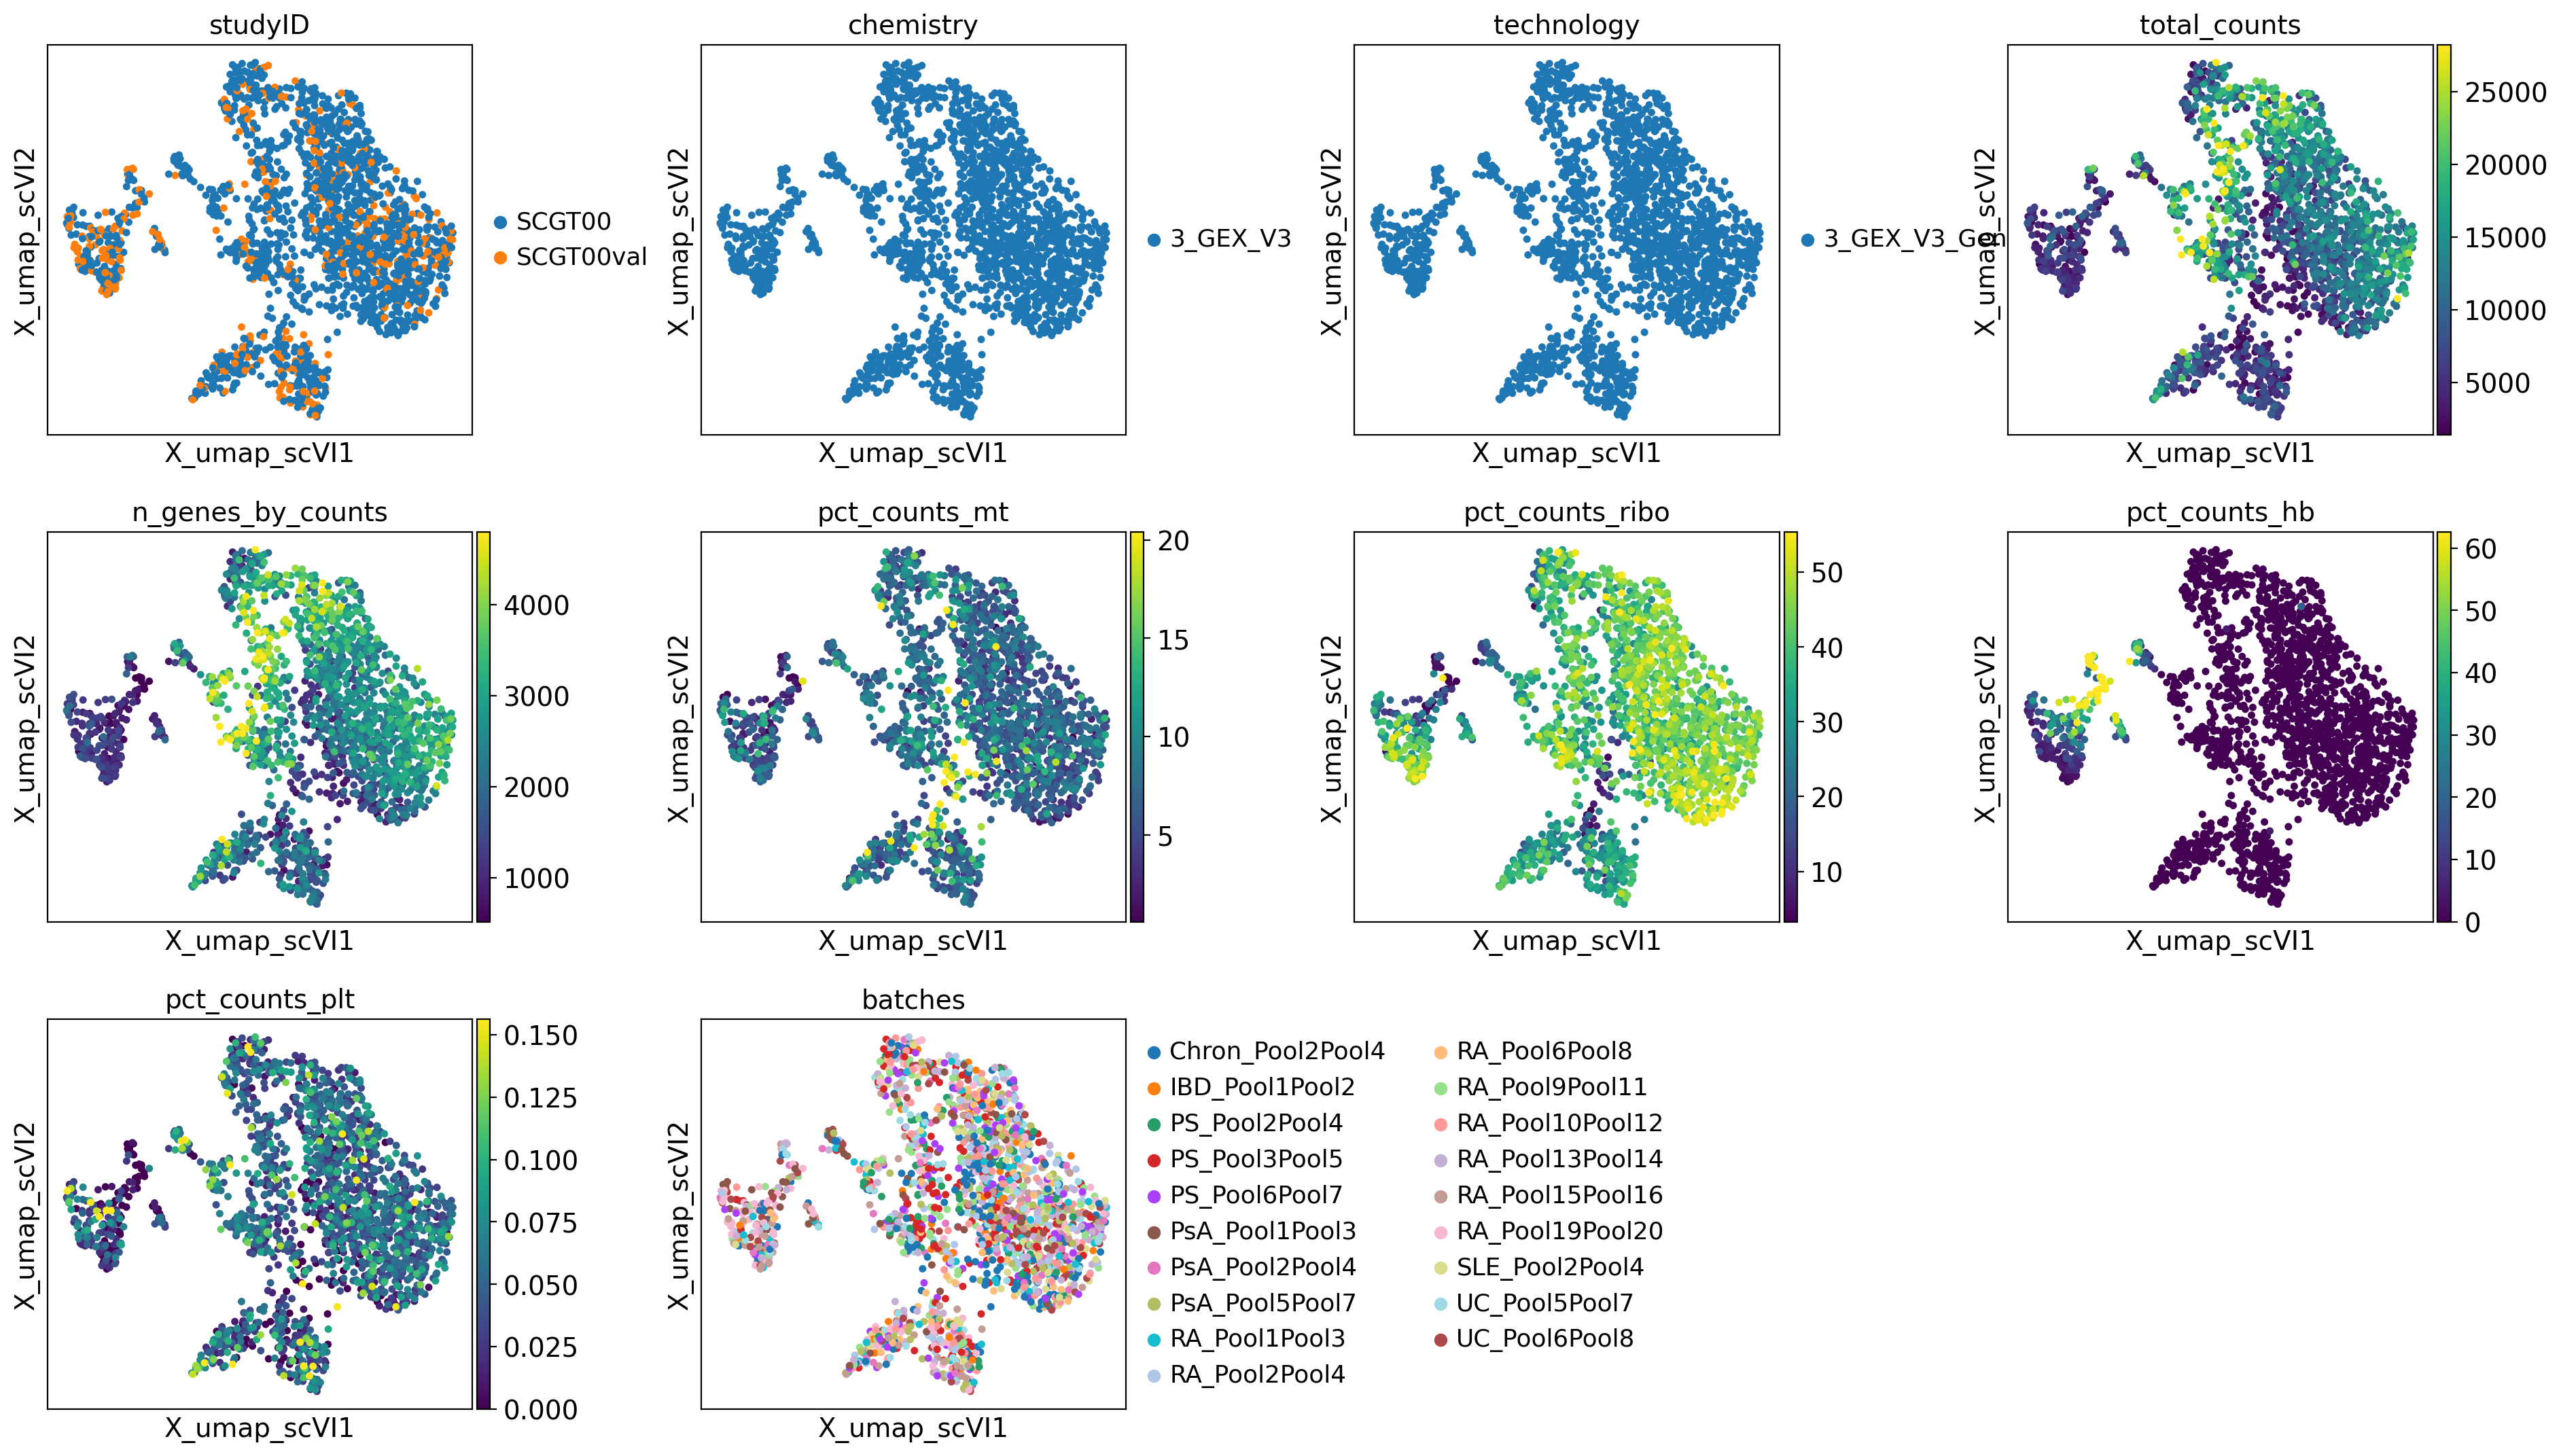

In [18]:
fig = sc.pl.embedding(adataSS, basis = 'X_umap_scVI', vmin='p1', vmax='p99', 
                 color=['studyID', 'chemistry', 'technology',
                        'total_counts', 'n_genes_by_counts', 
                        'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'pct_counts_plt', 
                       'batches'], 
                 wspace = 0.4, ncols = 4, return_fig=True)

if overwriteFigures:
    plt.savefig(here('{}/results/figures/03_UMAP_technicalFactors_scVI.pdf'.format(workDir)), 
                bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

## Clinical covariates

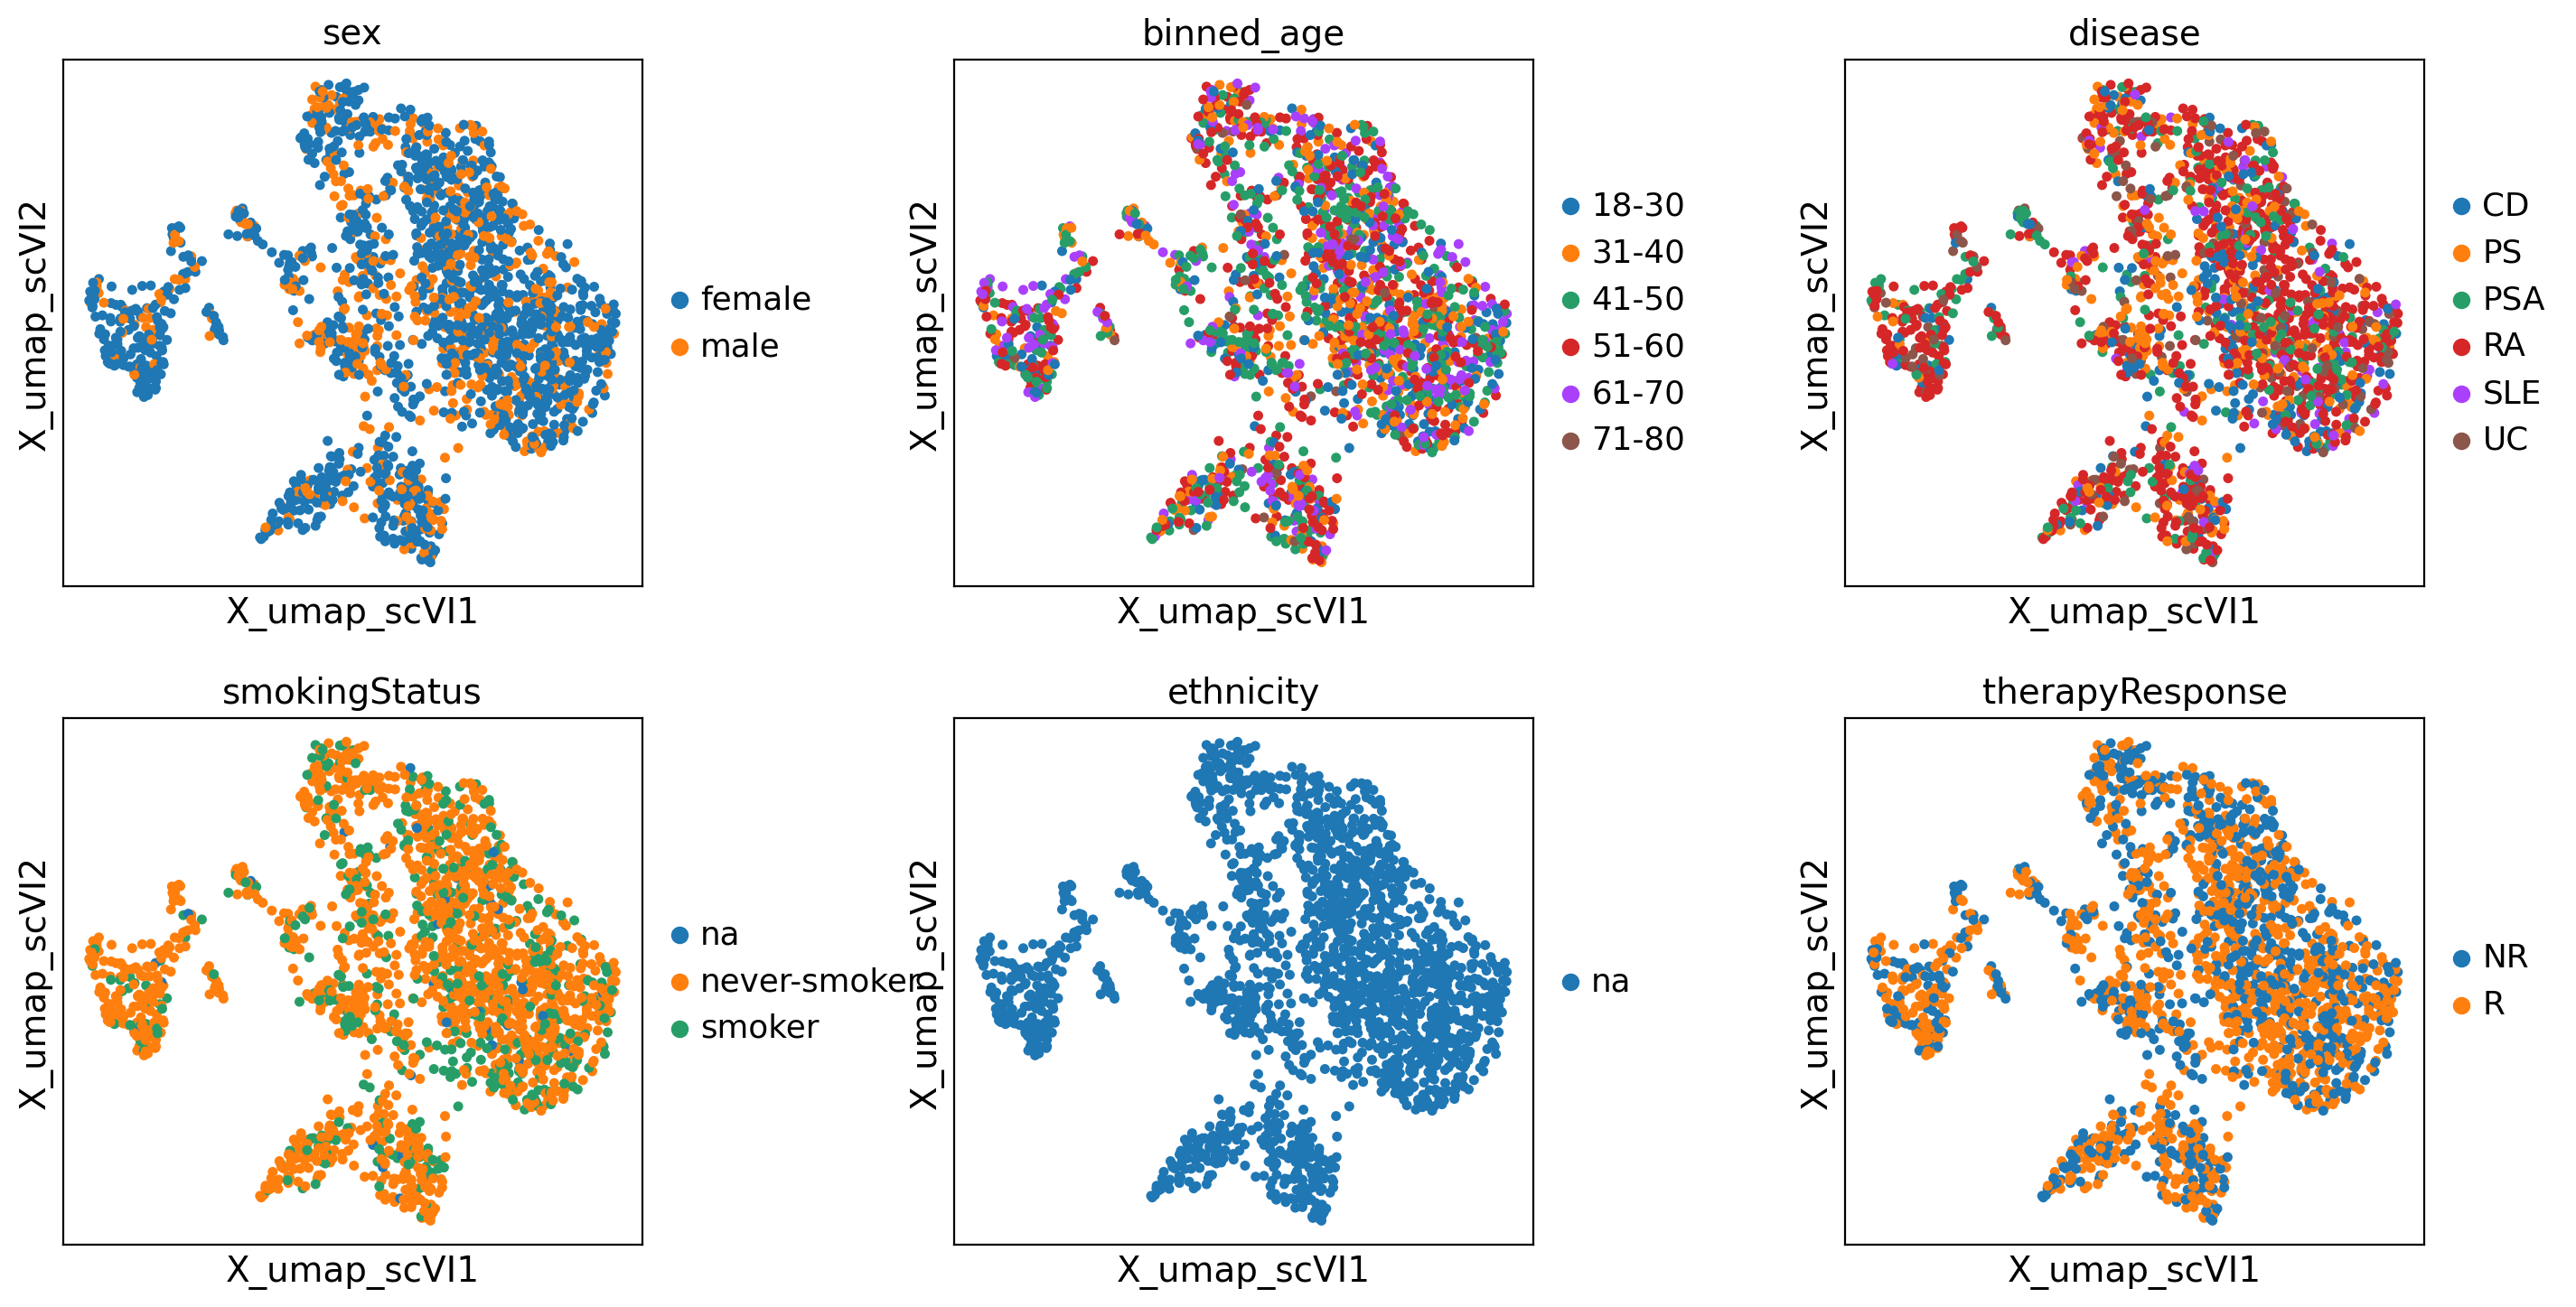

In [19]:
fig = sc.pl.embedding(adataSS, basis = 'X_umap_scVI', vmin='p1', vmax='p99',
                 color=['sex','binned_age', 'disease',
                       "smokingStatus", "ethnicity", "therapyResponse"], 
                 wspace = 0.4, ncols = 3, return_fig=True)

if overwriteFigures:
    plt.savefig(here('{}/results/figures/03_UMAP_clinicalFactors_scVI.pdf'.format(workDir)), 
                bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

## Cell cycling score

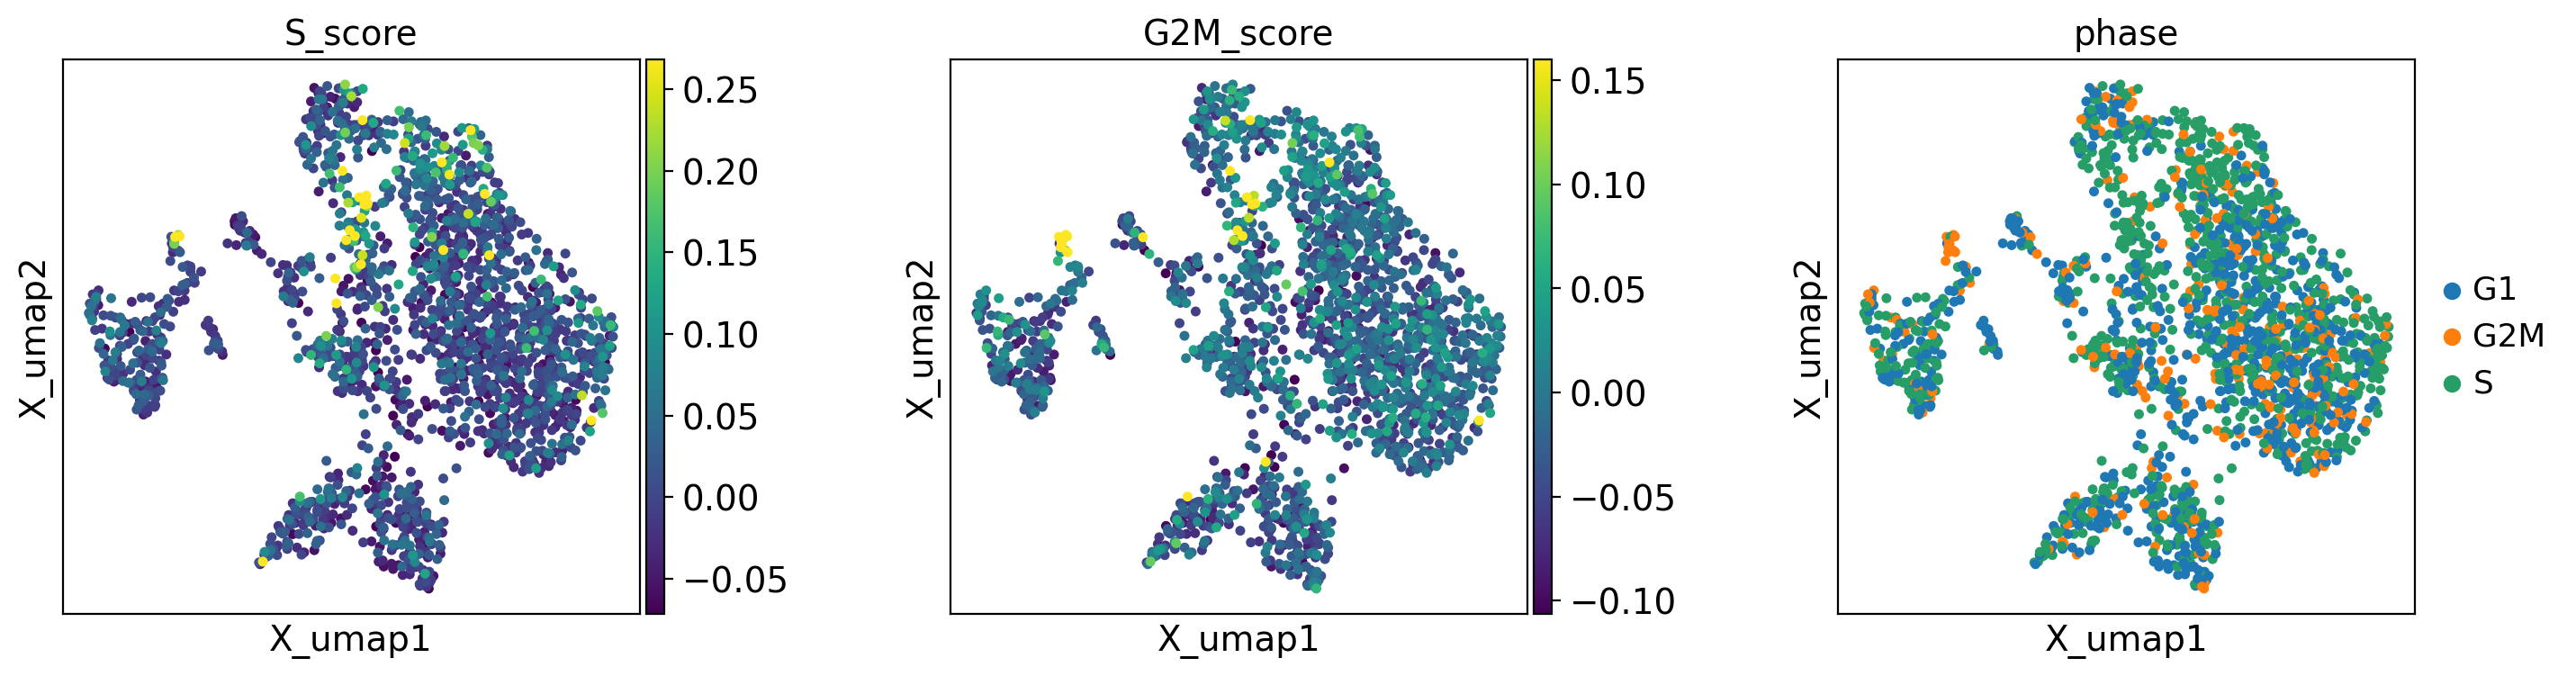

In [20]:
fig = sc.pl.embedding(adataSS, basis = 'X_umap', vmin='p1', vmax='p99',
                 ncols=3, color=['S_score', 'G2M_score', 'phase'], wspace = 0.4, return_fig=True)

if overwriteFigures:
    plt.savefig(here('{}/results/figures/03_UMAP_cellcyclingScore_scVI.pdf'.format(workDir)), 
                bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

In [ ]:
session_info.show()